In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"birdyedwards","key":"82a65b7a93dde126a291fbafd18605ba"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ankit1743/skyview-an-aerial-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset
License(s): CC0-1.0
skyview-an-aerial-landscape-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install tensorflow
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

In [ ]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U xgboost

In [ ]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U catboost

In [ ]:
!unzip skyview-an-aerial-landscape-dataset.zip -d /content/drive

Archive:  skyview-an-aerial-landscape-dataset.zip
replace /content/drive/Aerial_Landscapes/Agriculture/001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/Aerial_Landscapes/Agriculture/002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ==============================================================================
# name: split_dataset.py
# aim: Split aerial landscape classification dataset into train/val/test folders
# ==============================================================================

import os
import shutil
import random
from pathlib import Path

# split_dataset.py
random.seed(42)

original_dir = Path("/content/drive/Aerial_Landscapes")
output_dir = Path("datasets")
train_ratio, val_ratio = 0.7, 0.15

for split in ['train', 'val', 'test']:
    (output_dir / split).mkdir(parents=True, exist_ok=True)

for class_dir in original_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        split_dict = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split, imgs in split_dict.items():
            target_dir = output_dir / split / class_dir.name
            target_dir.mkdir(parents=True, exist_ok=True)
            for img_path in imgs:
                shutil.copy(img_path, target_dir / img_path.name)

print("✅ Dataset split complete.")


✅ Dataset split complete.


In [ ]:
import cv2
import numpy as np
from PIL import Image
from skimage.feature import local_binary_pattern

def extract_color_lbp_features(image, n_points=24, radius=8, method='uniform'):

    # Check if image is grayscale or color
    if len(image.shape) < 3:
        # For grayscale images, use regular LBP
        gray = image
        # Apply Gaussian blur to reduce noise
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        # Compute LBP
        lbp = local_binary_pattern(gray, n_points, radius, method)
        # Compute histogram of LBP
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        return hist

    # For color images, compute LBP on each channel
    # Split the image into its color channels
    channels = cv2.split(image)
    all_hists = []

    # Process each channel
    for channel in channels:
        # Apply Gaussian blur to reduce noise
        channel_blurred = cv2.GaussianBlur(channel, (3, 3), 0)

        # Compute LBP for this channel
        lbp = local_binary_pattern(channel_blurred, n_points, radius, method)

        # Compute histogram of LBP
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

        # Add to list of histograms
        all_hists.append(hist)

    # Concatenate histograms from all channels
    combined_hist = np.concatenate(all_hists)

    # Normalize the combined histogram
    if np.sum(combined_hist) > 0:
        combined_hist = combined_hist / np.sum(combined_hist)

    return combined_hist

# Advanced version that also extracts opponent color LBP features
def extract_advanced_color_lbp_features(image, n_points=24, radius=8, method='uniform', use_opponent=True):

    if len(image.shape) < 3:
        # For grayscale images, revert to standard LBP
        return extract_color_lbp_features(image, n_points, radius, method)

    all_hists = []

    # Process RGB channels
    channels = cv2.split(image)
    for channel in channels:
        # Apply Gaussian blur to reduce noise
        channel_blurred = cv2.GaussianBlur(channel, (3, 3), 0)

        # Compute LBP for this channel
        lbp = local_binary_pattern(channel_blurred, n_points, radius, method)

        # Compute histogram of LBP
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

        # Add to list of histograms
        all_hists.append(hist)

    # If enabled, process opponent color space (more discriminative for aerial imagery)
    if use_opponent and len(channels) == 3:
        # Create opponent color channels: O1 = (R-G)/sqrt(2), O2 = (R+G-2B)/sqrt(6), O3 = (R+G+B)/sqrt(3)
        R, G, B = channels
        R = R.astype(np.float32)
        G = G.astype(np.float32)
        B = B.astype(np.float32)

        O1 = (R - G) / np.sqrt(2)
        O2 = (R + G - 2 * B) / np.sqrt(6)
        O3 = (R + G + B) / np.sqrt(3)

        # Normalize to 0-255 range for LBP
        O1 = cv2.normalize(O1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        O2 = cv2.normalize(O2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        O3 = cv2.normalize(O3, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Process each opponent channel
        for opponent_channel in [O1, O2, O3]:
            # Apply Gaussian blur
            channel_blurred = cv2.GaussianBlur(opponent_channel, (3, 3), 0)

            # Compute LBP
            lbp = local_binary_pattern(channel_blurred, n_points, radius, method)

            # Compute histogram
            n_bins = int(lbp.max() + 1)
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

            # Add to list of histograms
            all_hists.append(hist)

    # Concatenate all histograms
    combined_hist = np.concatenate(all_hists)

    # Normalize the combined histogram
    if np.sum(combined_hist) > 0:
        combined_hist = combined_hist / np.sum(combined_hist)

    return combined_hist

# Function to extract multi-scale Color LBP features
def extract_multiscale_color_lbp(image, radii=[1, 3, 5, 8], n_points=24, method='uniform', use_opponent=False):

    # Initialize list to store histograms for each scale
    multiscale_hists = []

    # Extract LBP features at each scale (radius)
    for radius in radii:
        if use_opponent:
            hist = extract_advanced_color_lbp_features(image, n_points, radius, method, use_opponent)
        else:
            hist = extract_color_lbp_features(image, n_points, radius, method)
        multiscale_hists.append(hist)

    # Concatenate histograms from all scales
    combined_hist = np.concatenate(multiscale_hists)

    # Normalize the combined histogram
    if np.sum(combined_hist) > 0:
        combined_hist = combined_hist / np.sum(combined_hist)

    return combined_hist

In [ ]:
import cv2
import numpy as np
from PIL import Image

# Function to extract color SIFT features from an image.
def extract_color_sift_features(image, n_features=100, color_space='rgb'):

    # Check if image is grayscale
    if len(image.shape) < 3:
        # For grayscale images, use regular SIFT
        return extract_standard_sift(image, n_features)

    # Convert to RGB if needed (OpenCV uses BGR by default)
    if color_space != 'bgr':
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

    # Convert to the requested color space
    if color_space == 'rgb' or color_space == 'rgbnorm':
        # Ensure RGB order (OpenCV uses BGR)
        if len(image.shape) == 3 and image.shape[2] == 3:
            image_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_color = image

        # For normalized RGB, convert to RGB norm
        if color_space == 'rgbnorm':
            image_color = normalize_rgb(image_color)

    elif color_space == 'opponent':
        # Convert to opponent color space
        image_color = rgb_to_opponent(image)
    elif color_space == 'hsv':
        # Convert to HSV
        image_color = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    else:
        raise ValueError(f"Unsupported color space: {color_space}")

    # Split into channels
    channels = cv2.split(image_color)

    # Process each channel
    all_descriptors = []

    # Create SIFT detector
    sift = cv2.SIFT_create(nfeatures=n_features)

    for i, channel in enumerate(channels):
        # Ensure channel is in uint8 format
        if channel.dtype != np.uint8:
            channel = (channel * 255).astype(np.uint8)

        # Skip completely uniform channels (like HSV channels for grayscale images)
        if np.min(channel) == np.max(channel):
            continue

        # Detect keypoints and compute descriptors
        keypoints, descriptors = sift.detectAndCompute(channel, None)

        # If no keypoints were found, skip this channel
        if descriptors is None:
            continue

        # Add channel-specific descriptors to the list
        all_descriptors.append(descriptors)

    # Combine descriptors from all channels
    if not all_descriptors:
        # If no descriptors were found at all, return empty array with correct shape
        return np.zeros((0, 128))


    combined_descriptors = np.vstack(all_descriptors)

    # Ensure we have at least some features
    if combined_descriptors.shape[0] < 5:
        # Generate some random descriptors to avoid empty feature vectors
        random_descriptors = np.random.randn(5, 128).astype(np.float32)
        # Normalize them to have similar scale to SIFT descriptors
        for i in range(random_descriptors.shape[0]):
            random_descriptors[i] /= np.linalg.norm(random_descriptors[i])
        return random_descriptors

    return combined_descriptors

# Function to extract standard SIFT features from grayscale image
def extract_standard_sift(image, n_features=100):

    # Convert image to grayscale if it's not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Create SIFT detector
    sift = cv2.SIFT_create(nfeatures=n_features)

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # If no keypoints were found, return empty array with correct shape
    if descriptors is None:
        # SIFT descriptors are 128-dimensional
        return np.zeros((0, 128))

    # Ensure we have at least some sift features
    if descriptors.shape[0] < 5:
        # Generate some random descriptors to avoid empty feature vectors
        random_descriptors = np.random.randn(5, 128).astype(np.float32)
        # Normalize them to have similar scale to SIFT descriptors
        for i in range(random_descriptors.shape[0]):
            random_descriptors[i] /= np.linalg.norm(random_descriptors[i])
        return random_descriptors

    return descriptors

# Function to convert RGB image to opponent color space
def rgb_to_opponent(image):

    # Ensure the image is in RGB (not BGR)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image

    # Split into R, G, B channels
    R, G, B = cv2.split(image_rgb)
    R = R.astype(np.float32)
    G = G.astype(np.float32)
    B = B.astype(np.float32)

    # Create opponent color channels
    # O1 = (R-G)/sqrt(2)
    O1 = (R - G) / np.sqrt(2)
    # O2 = (R+G-2B)/sqrt(6)
    O2 = (R + G - 2*B) / np.sqrt(6)
    # O3 = (R+G+B)/sqrt(3)
    O3 = (R + G + B) / np.sqrt(3)

    # Normalize to 0-255 range for SIFT
    O1 = cv2.normalize(O1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    O2 = cv2.normalize(O2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    O3 = cv2.normalize(O3, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Merge channels
    opponent = cv2.merge([O1, O2, O3])
    return opponent

# Function to convert RGB to normalized RGB color space
def normalize_rgb(image):

    # Split into R, G, B channels
    R, G, B = cv2.split(image)
    R = R.astype(np.float32)
    G = G.astype(np.float32)
    B = B.astype(np.float32)

    # Calculate sum
    sum_rgb = R + G + B
    # Avoid division by zero
    sum_rgb[sum_rgb == 0] = 1

    # Normalize each channel
    r_norm = (R / sum_rgb * 255).astype(np.uint8)
    g_norm = (G / sum_rgb * 255).astype(np.uint8)
    b_norm = (B / sum_rgb * 255).astype(np.uint8)

    # Merge channels
    rgb_norm = cv2.merge([r_norm, g_norm, b_norm])
    return rgb_norm

# Extract SIFT features from multiple color spaces and combine them.
# This approach is more robust for aerial imagery where different
# color spaces can capture different types of features
def extract_multi_color_sift(image, n_features=100):

    # Define color spaces to use
    color_spaces = ['rgb', 'opponent', 'hsv']

    # Extract features from each color space
    all_descriptors = []
    for color_space in color_spaces:
        descriptors = extract_color_sift_features(image, n_features, color_space)
        if descriptors.shape[0] > 0:
            all_descriptors.append(descriptors)

    # Combine all descriptors
    if not all_descriptors:
        return np.zeros((0, 128))

    combined_descriptors = np.vstack(all_descriptors)
    return combined_descriptors

# Function to create a bag of visual words
def create_bag_of_visual_words(descriptors_list, n_clusters=50):

    # Stack all descriptors
    if not descriptors_list:
        print("Warning: No descriptors found for codebook creation. Creating default codebook.")
        return np.zeros((n_clusters, 128))

    # Filter out empty descriptor arrays
    valid_descriptors = [d for d in descriptors_list if d.shape[0] > 0]

    if not valid_descriptors:
        print("Warning: No valid descriptors found. Creating default codebook.")
        return np.zeros((n_clusters, 128))

    all_descriptors = np.vstack(valid_descriptors)

    if all_descriptors.shape[0] < n_clusters:
        print(f"Warning: Number of descriptors ({all_descriptors.shape[0]}) is less than requested clusters ({n_clusters}).")
        print(f"Reducing number of clusters to {all_descriptors.shape[0]}.")
        n_clusters = all_descriptors.shape[0]

    print(f"Creating codebook with {n_clusters} clusters from {all_descriptors.shape[0]} descriptors.")

    # Create and train KMeans
    try:
        kmeans = cv2.kmeans(
            all_descriptors.astype(np.float32),
            n_clusters,
            None,
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
            attempts=10,
            flags=cv2.KMEANS_RANDOM_CENTERS
        )

        return kmeans[2]  # Return the cluster centers

    except Exception as e:
        print(f"Error in K-means clustering: {e}")
        print("Creating fallback random codebook.")
        return np.random.randn(n_clusters, 128).astype(np.float32)

def compute_bovw_features(descriptors, codebook):

    # Initialize histogram
    hist = np.zeros(len(codebook))

    # Exit if no descriptors were found
    if descriptors.shape[0] == 0:
        return hist

    # normalise the descriptors and codebook for better distance calculation
    normalised_descriptors = np.copy(descriptors)
    for i in range(normalised_descriptors.shape[0]):
        norm = np.linalg.norm(normalised_descriptors[i])
        if norm > 0:
            normalised_descriptors[i] /= norm

    normalised_codebook = np.copy(codebook)
    for i in range(normalised_codebook.shape[0]):
        norm = np.linalg.norm(normalised_codebook[i])
        if norm > 0:
            normalised_codebook[i] /= norm

    # Assign each descriptor to the nearest visual word using Euclidean distance
    for descriptor in normalised_descriptors:
        distances = np.sqrt(((normalised_codebook - descriptor)**2).sum(axis=1))
        nearest_word = np.argmin(distances)
        hist[nearest_word] += 1

    # normalise histogram
    if np.sum(hist) > 0:
        hist = hist / np.sum(hist)

    return hist

In [ ]:
import numpy as np
from PIL import Image

# Class to handle feature extraction from images
class FeatureExtractor:

    def __init__(self, feature_type='combined', use_codebook=True):
        self.feature_type = feature_type
        self.use_codebook = use_codebook
        self.codebook = None
        self.fixed_lbp_size = None
        self.use_opponent = True

        # SIFT parameters
        self.sift_n_features = 100
        self.sift_color_space = 'opponent'

        # LBP parameters
        self.lbp_n_points = 24
        self.lbp_method = 'uniform'
        self.lbp_radii = [1, 3, 5, 8]
        self.lbp_radius = 8

    def extract_from_tensor(self, tensor):
        # Convert tensor to numpy (H, W, C)
        image = tensor.permute(1, 2, 0).cpu().numpy()

        # Convert from normalised range back to [0, 255]
        # First check if we need denormalisation (values in range approximately [-1, 1])
        if image.min() < 0 or image.max() <= 1.0:
            # Standard ImageNet normalisation was applied
            # Undo normalisation: first multiply by std then add back mean
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            # Scale from [0, 1] to [0, 255]
            image = (image * 255).astype(np.uint8)

        return self.extract_from_numpy(image)

    def extract_from_numpy(self, image):
        features = []

        if self.feature_type == 'sift' or self.feature_type == 'combined':
            if self.use_codebook and self.codebook is not None:
                # Extract SIFT features and compute bag of visual words
                descriptors = extract_multi_color_sift(image, self.sift_n_features)
                bovw_features = compute_bovw_features(descriptors, self.codebook)
                features.append(bovw_features)
            else:
                # Just extract SIFT descriptors for codebook creation
                descriptors = extract_multi_color_sift(image, self.sift_n_features)
                if descriptors.shape[0] > 0:
                    return descriptors

        if self.feature_type == 'lbp' or self.feature_type == 'combined':
            # Extract LBP features
            lbp_features = extract_multiscale_color_lbp(image, self.lbp_radii, self.lbp_n_points, self.lbp_method, self.use_opponent)
            # Store standard size if not already set
            if self.fixed_lbp_size is None:
                self.fixed_lbp_size = len(lbp_features)
            # Ensure consistent size by padding or truncating
            elif len(lbp_features) != self.fixed_lbp_size:
                if len(lbp_features) < self.fixed_lbp_size:
                    # Pad with zeros
                    lbp_features = np.pad(lbp_features, (0, self.fixed_lbp_size - len(lbp_features)))
                else:
                    # Truncate
                    lbp_features = lbp_features[:self.fixed_lbp_size]

            features.append(lbp_features)

        # Combine features
        if len(features) > 0:
            if len(features) == 1:
                return features[0]
            else:
                return np.concatenate(features)

        return None

    def create_codebook(self, dataloader, n_clusters=100):
        print("Extracting SIFT descriptors for codebook creation...")
        all_descriptors = []

        # Extract SIFT descriptors from all images in the dataloader
        for batch_idx, (images, _) in enumerate(dataloader):
            if batch_idx % 5 == 0:
                print(f"  Processing batch {batch_idx}/{len(dataloader)}")

            # Process each image in the batch
            for img in images:
                # Convert to numpy and extract features
                img_np = img.permute(1, 2, 0).cpu().numpy()

                # Undo normalisation properly
                img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img_np = (img_np * 255).astype(np.uint8)

                descriptors = extract_multi_color_sift(img_np, n_features=200) # Extract more features
                if descriptors.shape[0] > 0:
                    all_descriptors.append(descriptors)

        # Create the codebook
        # Increase n_clusters for better representation
        self.codebook = create_bag_of_visual_words(all_descriptors, n_clusters=max(n_clusters, 200))
        return self.codebook

    def extract_features_batch(self, dataloader):
        features = []
        labels = []

        # Set up progress tracking
        total_batches = len(dataloader)

        for batch_idx, (images, targets) in enumerate(dataloader):
            if batch_idx % 5 == 0:
                print(f"  Processing batch {batch_idx}/{total_batches} ({batch_idx/total_batches*100:.1f}%)")

            batch_features = []

            for img in images:
                img_features = self.extract_from_tensor(img)

                # Handle the case where features might be None
                if img_features is None:
                    # Use a default feature vector with appropriate dimensionality
                    if self.feature_type == 'sift':
                        default_size = len(self.codebook) if self.codebook is not None else 100
                    elif self.feature_type == 'lbp':
                        default_size = self.fixed_lbp_size or 26  # Default LBP size
                    else:  # combined
                        codebook_size = len(self.codebook) if self.codebook is not None else 100
                        lbp_size = self.fixed_lbp_size or 26
                        default_size = codebook_size + lbp_size

                    img_features = np.zeros(default_size)

                batch_features.append(img_features)

            features.extend(batch_features)
            labels.extend(targets.cpu().numpy())

        # Convert to numpy arrays and ensure consistent shapes
        features_array = np.array(features)
        labels_array = np.array(labels)

        # Check for NaN or infinity values
        if np.isnan(features_array).any() or np.isinf(features_array).any():
            print("Warning: NaN or infinity values detected in features. Replacing with zeros.")
            features_array = np.nan_to_num(features_array, nan=0.0, posinf=0.0, neginf=0.0)

        return features_array, labels_array

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr  4 23:29:21 2025

@author: MIS
"""

import cv2
import os
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torchvision.utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Get path for dataset, train, val and test
datasets_dir = Path("datasets")
train_dir = datasets_dir / "train"
val_dir = datasets_dir / "val"
test_dir = datasets_dir / "test"

# Contrast never exceeds 80 which may also be problematic
# As contrast is important for distinguishing features, low contrast
# makes it more difficult for the model to differentiate textures.
# Features may look too similar, reducing the model’s ability to distinguish different terrain types.
# If contrast in real-world test images is higher, the model might not generalize well.
# Adjusts pixel values so that the output image's histogram is more uniform
# Spreads out the most frequent intensity values across the available range
def enhance_contrast(img):
    # Convert PIL Image to numpy array if needed
    if isinstance(img, Image.Image):
        img = np.array(img)

    # Check if the image is grayscale or color
    if len(img.shape) == 2:
        # Image is already grayscale
        result = cv2.equalizeHist(img)

    elif len(img.shape) == 3:
        # For color images, convert to Lab color space
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

        # Configure CLAHE with clip limit of 2 and tile grid size of (8, 8)
        clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))

        # Apply CLAHE to the L channel only
        lab[:,:,0] = clahe.apply(lab[:,:,0])

        # Convert back to RGB
        result = cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

    # Convert back to PIL Image if input was PIL
    if isinstance(img, Image.Image):
        result = Image.fromarray(result)

    return result

# Recall lab 1 - Unsharp masking allows control over the amount and radius of sharpening
# within the same image via Gaussian filtering
# The Laplacian method emphasizes all edges equally (even weak edges)
# and is therefore best suited to restoring missing details.
# Unsharp masking on the other hand enhances existing edges but doesn’t create new ones.
def sharpen_image(img, amount=0.5):
    # Convert PIL Image to numpy array if needed
    if isinstance(img, Image.Image):
        img = np.array(img)

    # Create blurred version
    blurred = cv2.GaussianBlur(img, (0, 0), 3)

    # Apply unsharp mask
    sharpened = cv2.addWeighted(img, 1.0 + amount, blurred, -amount, 0)

    # Convert back to PIL Image if input was PIL
    if isinstance(img, Image.Image):
        sharpened = Image.fromarray(sharpened)

    return sharpened

class RandomOcclusion(nn.Module):

    def __init__(self, size_range=(10, 50), count_range=(1, 5), fill_value=0):

        super().__init__()
        self.size_range = size_range
        self.count_range = count_range
        self.fill_value = fill_value

    def forward(self, img):

        # Convert to tensor if it's a PIL Image
        if isinstance(img, Image.Image):
            img_tensor = F.to_tensor(img)
        else:
            img_tensor = img.clone()

        # Get dimensions
        _, height, width = img_tensor.shape

        # Determine number of occlusions
        num_occlusions = random.randint(self.count_range[0], self.count_range[1])

        # Apply occlusions
        for _ in range(num_occlusions):
            # Determine occlusion size
            h_size = random.randint(self.size_range[0], self.size_range[1])
            w_size = random.randint(self.size_range[0], self.size_range[1])

            # Determine occlusion location
            y = random.randint(0, height - h_size)
            x = random.randint(0, width - w_size)

            # Apply occlusion
            img_tensor[:, y:y + h_size, x:x + w_size] = self.fill_value

        # Convert back to PIL if input was PIL
        if isinstance(img, Image.Image):
            return F.to_pil_image(img_tensor)

        return img_tensor

# Custom transform for applying contrast enhancement and sharpening
class EnhancementTransform(nn.Module):
    def __init__(self, sharpen_amount=0.3, apply_contrast=True):
        super().__init__()
        self.sharpen_amount = sharpen_amount
        self.apply_contrast = apply_contrast

    def forward(self, img):
        # Convert to numpy for OpenCV operations
        np_img = np.array(img)

        # Apply sharpening
        np_img = sharpen_image(np_img, self.sharpen_amount)

        # Apply contrast enhancement if enabled
        if self.apply_contrast:
            np_img = enhance_contrast(np_img)

        # Convert back to PIL Image
        return Image.fromarray(np_img.astype(np.uint8))

# Dataset class for loading and augmenting images
class ImageDataset(Dataset):
    def __init__(self, images_dir, transform=None, sample_size=None, random_seed=42):
        self.transform = transform

        np.random.seed(random_seed)
        random.seed(random_seed)
        torch.manual_seed(random_seed)

        # Get list of class directories
        self.class_dirs = [d for d in Path(images_dir).iterdir() if d.is_dir()]

        # Create class indices mapping
        self.class_to_idx = {class_dir.name: i for i, class_dir in enumerate(sorted(self.class_dirs))}

        # Load images and labels
        self.imgs = []
        self.labels = []

        # Process each class
        for class_dir in sorted(self.class_dirs):
            class_name = class_dir.name
            class_idx = self.class_to_idx[class_name]

            # Get all image files for this class
            image_paths = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))

            # Sample if needed
            if sample_size is not None and len(image_paths) > sample_size:
                image_paths = np.random.choice(image_paths, size=sample_size, replace=False)

            print(f"Processing {len(image_paths)} images for class '{class_name}'")

            # Store paths and labels
            for img_path in image_paths:
                self.imgs.append(str(img_path))
                self.labels.append(class_idx)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.imgs)

class AugmentationGenerator:
    # 224×224 is a standard size used by many pre-trained CNN models like VGG16, ResNet50, etc.
    # These models were trained on ImageNet using this image size, so it became a common default.
    # 224×224 provides a good balance between detail preservation and processing speed (compared to larger sizes like 256×256).

    # Batch size - the number of samples (images in this case) that will be processed together in a single forward/backward pass through the system.
    # Smaller batches provide more noisy gradients which can sometimes help escape local minima
    # Larger batches provide more stable gradient estimates but may converge to sharper minima
    # Batch size of 32 is often considered a good compromise
    def __init__(self, img_height=224, img_width=224, sharpen_amount=0.3, contrast_enhancement=True,
                 use_occlusion=True, occlusion_size=(10, 30), occlusion_count=(1, 2)):
        self.img_height = img_height

        # Create the transformation pipeline for training data with augmentation
        # Create list of transforms
        train_transforms = [
            transforms.Resize((img_height, img_width)),
            EnhancementTransform(sharpen_amount, contrast_enhancement),
            transforms.Pad(padding=224, padding_mode='reflect'),
            transforms.RandomRotation(20),
            transforms.CenterCrop((224, 224)),
            transforms.ColorJitter(
                # Normally setting adjustment factor to be between 0.7 and 1.3 helps
                # keep brightness changes within a realistic range without making images too dark (unusable)
                # or too bright (washed out).
                # Too dark  = loss of detail.
                # Too bright = overexposure, washed-out colors.
                brightness=(0.6, 1.1),  # Brightness range
            ),
            # As the dataset is comprised of aerial views which include symmetric objects
            # both horizontal and vertical flips are used
            # these flips can improve model robustness
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),

        ]

        # Add occlusion if enabled
        if use_occlusion:
            train_transforms.append(
                RandomOcclusion(size_range=occlusion_size, count_range=occlusion_count)
            )

        # Add final conversion and normalization
        train_transforms.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])

        # Create the transformation pipeline
        self.train_transform = transforms.Compose(train_transforms)

        # Basic transformation for validation/test without augmentations
        self.val_transform = transforms.Compose([
            transforms.Resize((img_height, img_width)),
            EnhancementTransform(sharpen_amount, contrast_enhancement),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # Create datasets for training, validation and optionally testing
    def create_datasets(self, train_dir, val_dir, test_dir=None, sample_size=None, val_sample_size=None, test_sample_size=None):

        # If val_sample_size is not provided, use the same as training sample size
        if val_sample_size is None:
            val_sample_size = sample_size

        train_dataset = ImageDataset(train_dir, transform=self.train_transform, sample_size=sample_size)
        val_dataset = ImageDataset(val_dir, transform=self.val_transform, sample_size=val_sample_size)

        if test_dir is not None:
            test_dataset = ImageDataset(test_dir, transform=self.val_transform, sample_size=test_sample_size)
            return train_dataset, val_dataset, test_dataset

        return train_dataset, val_dataset

    # Create data loaders for training, validation and optionally testing
    def create_dataloaders(self, train_dir, val_dir, test_dir=None, batch_size=32, sample_size=None, val_sample_size=None, test_sample_size=None):

        if test_dir is not None:
            train_dataset, val_dataset, test_dataset = self.create_datasets(
                train_dir, val_dir, test_dir,
                sample_size=sample_size,
                val_sample_size=val_sample_size,
                test_sample_size=test_sample_size
            )

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)

            return train_loader, val_loader, test_loader
        else:
            train_dataset, val_dataset = self.create_datasets(
                train_dir, val_dir,
                sample_size=sample_size,
                val_sample_size=val_sample_size
            )

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

            return train_loader, val_loader

def visualize_augmentations(image_path, n_augmentations=5, use_occlusion=True):

    # Load image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))

    # Apply enhancements first
    np_img = np.array(img)
    enhanced_img = enhance_contrast(sharpen_image(np_img))
    enhanced_pil = Image.fromarray(enhanced_img.astype(np.uint8))

    # Create list of transforms
    augment_transforms = [
        transforms.Resize((224, 224)),
        EnhancementTransform(0.3, True),
        transforms.Pad(padding=224, padding_mode='reflect'),
        transforms.RandomRotation(20),
        transforms.CenterCrop((224, 224)),
        transforms.ColorJitter(brightness=(0.6, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]

    # Add occlusion if enabled
    if use_occlusion:
        augment_transforms.append(
            RandomOcclusion(size_range=(10, 30), count_range=(1, 2))
        )

    # Create augmentation transform
    augment_transform = transforms.Compose(augment_transforms)

    # Create figure
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, n_augmentations + 2, 1)
    plt.imshow(np_img)
    plt.title('Original')
    plt.axis('off')

    # Plot enhanced image
    plt.subplot(1, n_augmentations + 2, 2)
    plt.imshow(enhanced_img)
    plt.title('Enhanced')
    plt.axis('off')

    # Generate and plot augmented images
    for i in range(n_augmentations):
        # Apply augmentations
        augmented = augment_transform(enhanced_pil)

        # Convert to numpy for display
        augmented_np = np.array(augmented)

        # Display
        plt.subplot(1, n_augmentations + 2, i + 3)
        plt.imshow(augmented_np)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print(augment_transforms)


if __name__ == "__main__":
    # This code runs when the script is executed directly
    # Example: Generate augmentations for a single image

    # Load an example image
    img_path = "datasets/train/Airport/121.jpg"
    if os.path.exists(img_path):
        # Visualize augmentations
        visualize_augmentations(img_path, n_augmentations=5, use_occlusion=True)


    else:
        print(f"Example image not found at {img_path}")

Example image not found at datasets/train/Airport/121.jpg


Using device: cpu
FULL DATASET MODE: Using all available images

Step 1: Creating dataloaders...
Processing 560 images for class 'Agriculture'
Processing 560 images for class 'Airport'
Processing 560 images for class 'Beach'
Processing 560 images for class 'City'
Processing 560 images for class 'Desert'
Processing 560 images for class 'Forest'
Processing 560 images for class 'Grassland'
Processing 560 images for class 'Highway'
Processing 560 images for class 'Lake'
Processing 560 images for class 'Mountain'
Processing 560 images for class 'Parking'
Processing 560 images for class 'Port'
Processing 560 images for class 'Railway'
Processing 560 images for class 'Residential'
Processing 560 images for class 'River'
Processing 120 images for class 'Agriculture'
Processing 120 images for class 'Airport'
Processing 120 images for class 'Beach'
Processing 120 images for class 'City'
Processing 120 images for class 'Desert'
Processing 120 images for class 'Forest'
Processing 120 images for cl

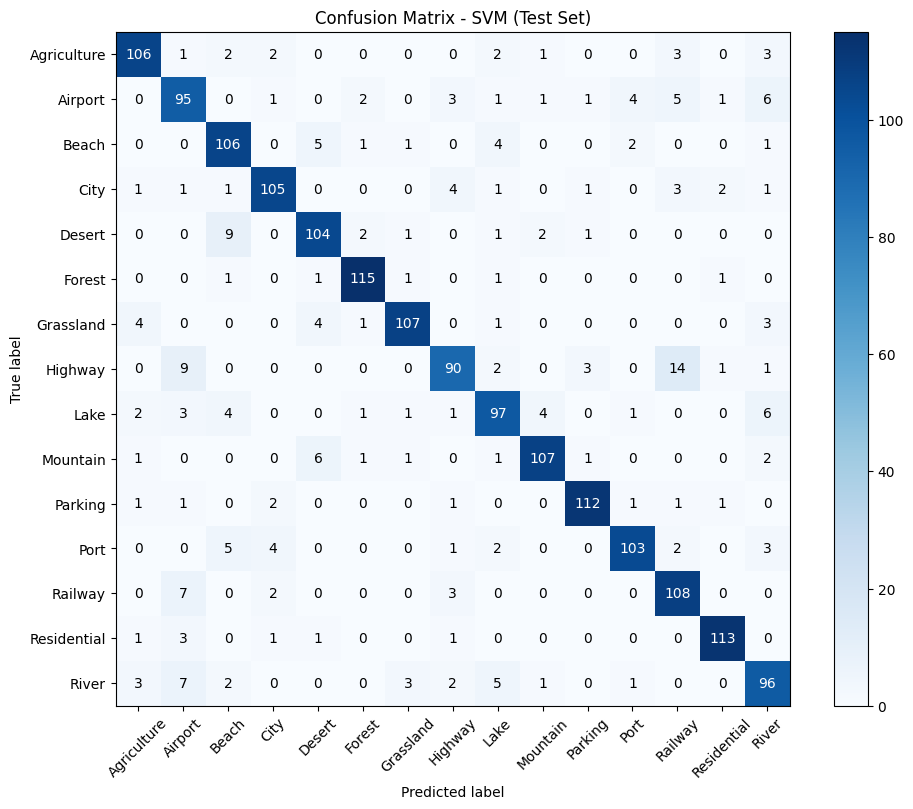


KNN Test Accuracy: 0.7661
KNN Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.72      0.81      0.76       120
     Airport       0.55      0.69      0.61       120
       Beach       0.72      0.78      0.75       120
        City       0.77      0.84      0.80       120
      Desert       0.81      0.65      0.72       120
      Forest       0.91      0.93      0.92       120
   Grassland       0.84      0.77      0.80       120
     Highway       0.73      0.62      0.67       120
        Lake       0.75      0.67      0.70       120
    Mountain       0.79      0.80      0.79       120
     Parking       0.96      0.86      0.91       120
        Port       0.84      0.80      0.82       120
     Railway       0.69      0.73      0.71       120
 Residential       0.84      0.93      0.89       120
       River       0.66      0.61      0.63       120

    accuracy                           0.77      1800
   macro avg       0.77   

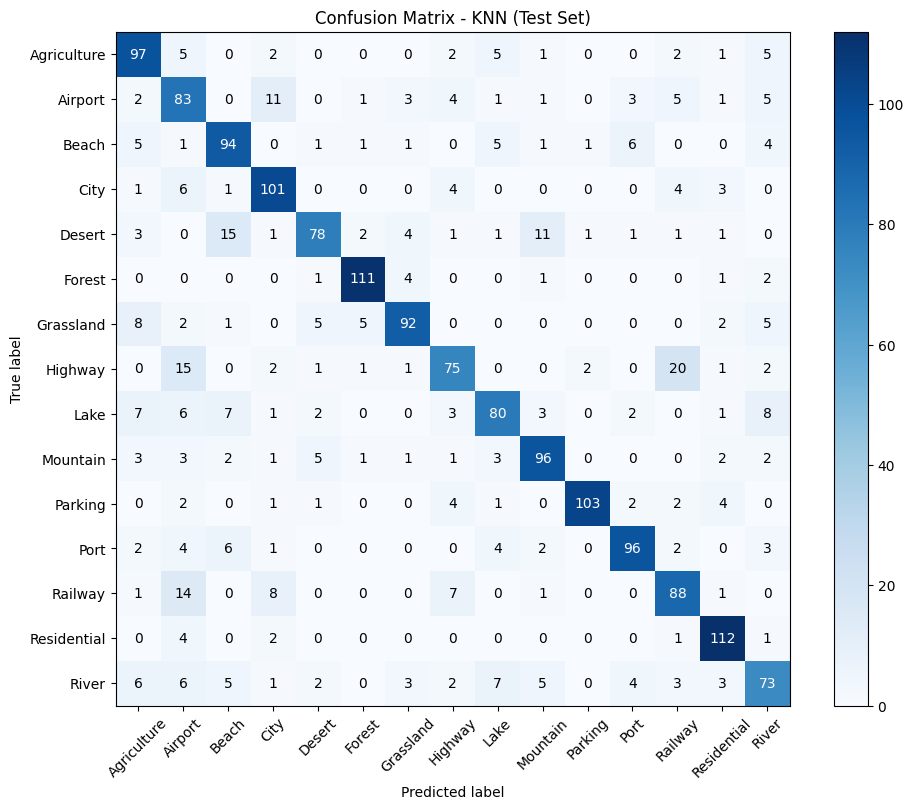


RF Test Accuracy: 0.7972
RF Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.84      0.85      0.84       120
     Airport       0.77      0.57      0.65       120
       Beach       0.75      0.83      0.79       120
        City       0.79      0.86      0.82       120
      Desert       0.78      0.75      0.76       120
      Forest       0.82      0.88      0.85       120
   Grassland       0.80      0.82      0.81       120
     Highway       0.73      0.71      0.72       120
        Lake       0.81      0.68      0.74       120
    Mountain       0.76      0.87      0.81       120
     Parking       0.96      0.88      0.92       120
        Port       0.87      0.87      0.87       120
     Railway       0.74      0.83      0.78       120
 Residential       0.85      0.93      0.89       120
       River       0.69      0.64      0.66       120

    accuracy                           0.80      1800
   macro avg       0.80     

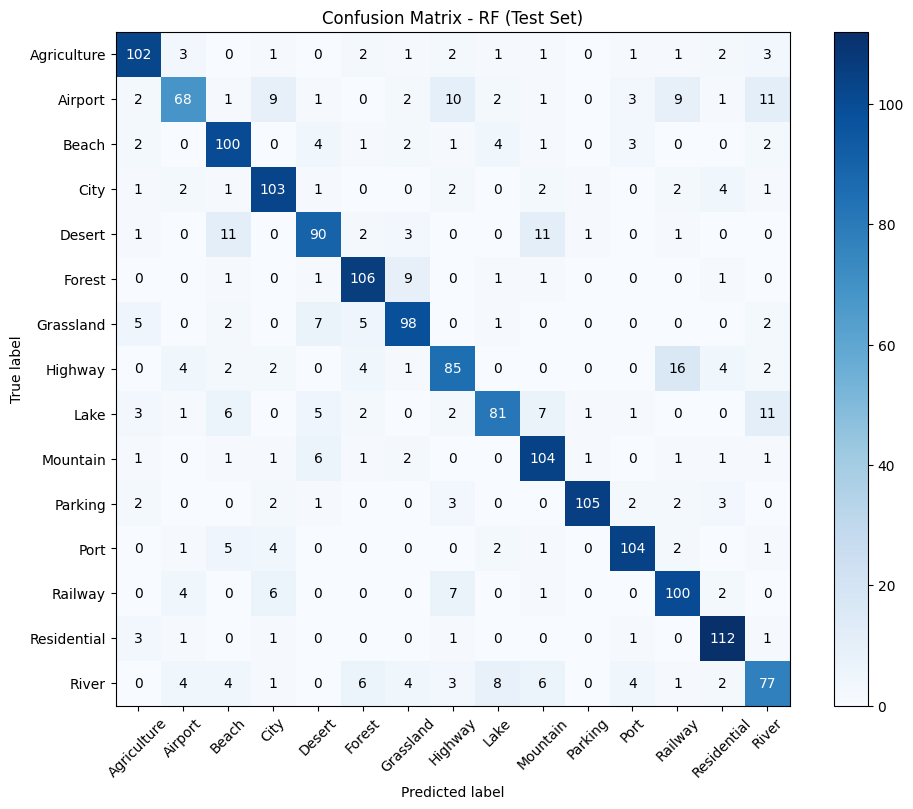


XGBoost Test Accuracy: 0.8089
XGBoost Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.81      0.78      0.80       120
     Airport       0.65      0.72      0.68       120
       Beach       0.81      0.83      0.82       120
        City       0.81      0.82      0.82       120
      Desert       0.82      0.80      0.81       120
      Forest       0.93      0.95      0.94       120
   Grassland       0.85      0.82      0.83       120
     Highway       0.76      0.67      0.71       120
        Lake       0.76      0.73      0.75       120
    Mountain       0.86      0.84      0.85       120
     Parking       0.95      0.90      0.92       120
        Port       0.89      0.84      0.86       120
     Railway       0.78      0.81      0.79       120
 Residential       0.90      0.90      0.90       120
       River       0.61      0.72      0.66       120

    accuracy                           0.81      1800
   macro avg      

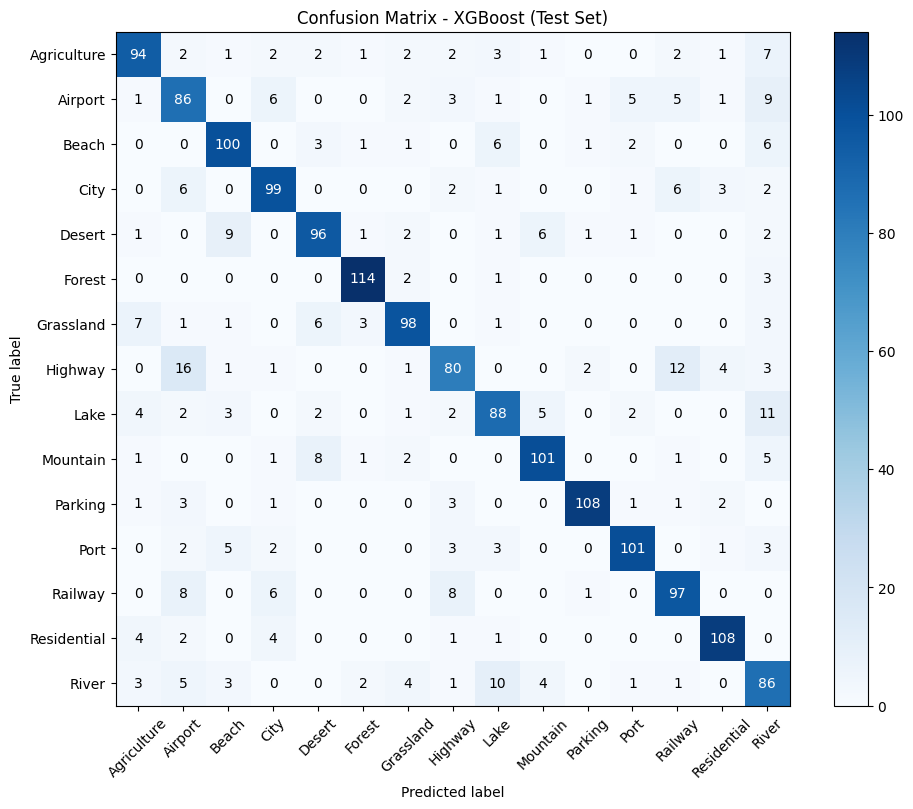


CatBoost Test Accuracy: 0.7961
CatBoost Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.82      0.84      0.83       120
     Airport       0.65      0.66      0.66       120
       Beach       0.82      0.81      0.81       120
        City       0.78      0.82      0.80       120
      Desert       0.83      0.80      0.81       120
      Forest       0.87      0.89      0.88       120
   Grassland       0.83      0.80      0.82       120
     Highway       0.74      0.62      0.67       120
        Lake       0.71      0.64      0.68       120
    Mountain       0.84      0.90      0.87       120
     Parking       0.88      0.88      0.88       120
        Port       0.87      0.85      0.86       120
     Railway       0.72      0.78      0.75       120
 Residential       0.90      0.93      0.91       120
       River       0.67      0.72      0.70       120

    accuracy                           0.80      1800
   macro avg    

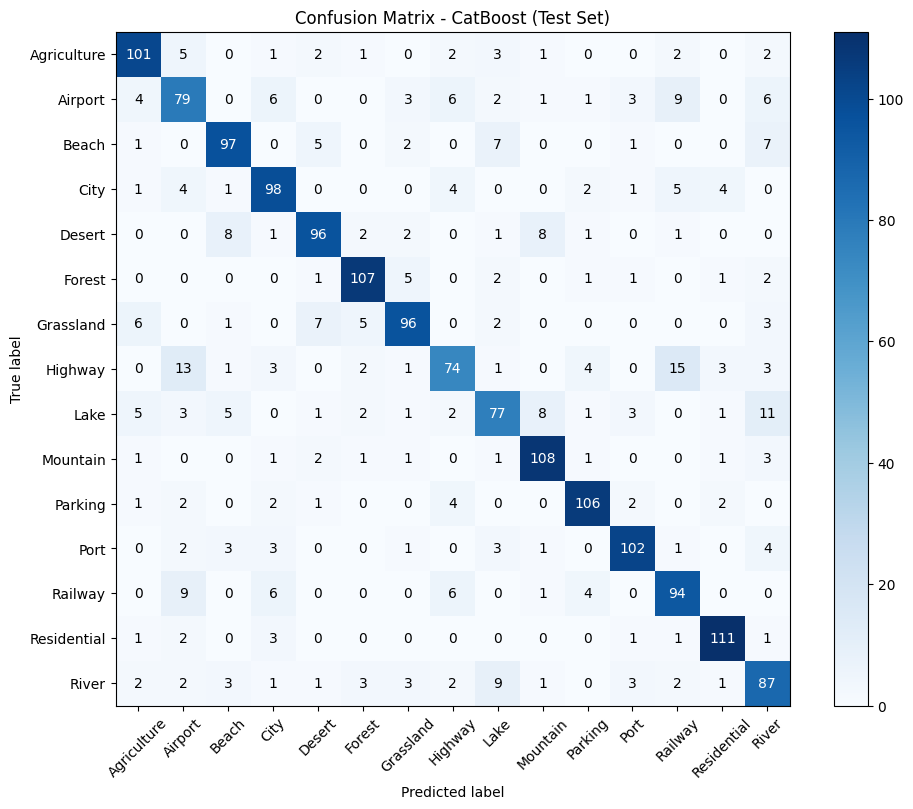


LogisticRegression Test Accuracy: 0.8183
LogisticRegression Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.85      0.80      0.82       120
     Airport       0.73      0.81      0.77       120
       Beach       0.83      0.88      0.86       120
        City       0.80      0.80      0.80       120
      Desert       0.87      0.86      0.87       120
      Forest       0.91      0.89      0.90       120
   Grassland       0.85      0.91      0.88       120
     Highway       0.77      0.73      0.75       120
        Lake       0.74      0.69      0.72       120
    Mountain       0.85      0.86      0.85       120
     Parking       0.91      0.90      0.90       120
        Port       0.91      0.82      0.86       120
     Railway       0.70      0.75      0.72       120
 Residential       0.87      0.89      0.88       120
       River       0.69      0.68      0.68       120

    accuracy                           0.82      1

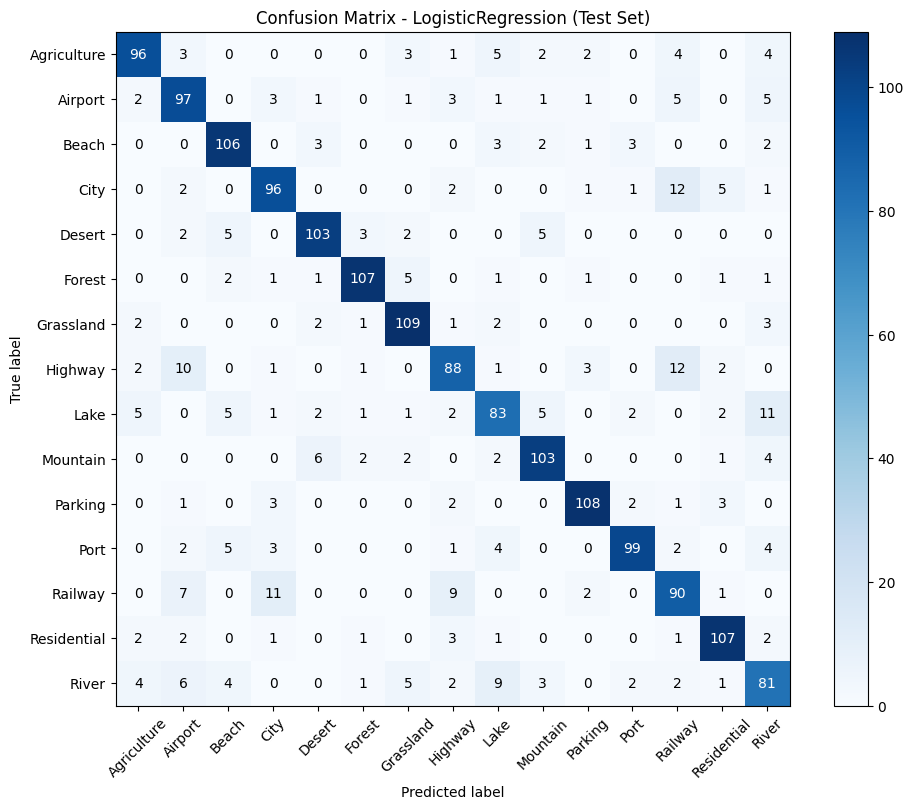


Stacking Test Accuracy: 0.8600
Stacking Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.88      0.86      0.87       120
     Airport       0.76      0.80      0.78       120
       Beach       0.83      0.89      0.86       120
        City       0.89      0.88      0.88       120
      Desert       0.83      0.87      0.85       120
      Forest       0.94      0.95      0.95       120
   Grassland       0.92      0.87      0.89       120
     Highway       0.87      0.73      0.80       120
        Lake       0.79      0.78      0.79       120
    Mountain       0.91      0.84      0.87       120
     Parking       0.94      0.95      0.95       120
        Port       0.93      0.88      0.90       120
     Railway       0.78      0.89      0.83       120
 Residential       0.95      0.94      0.95       120
       River       0.72      0.78      0.75       120

    accuracy                           0.86      1800
   macro avg    

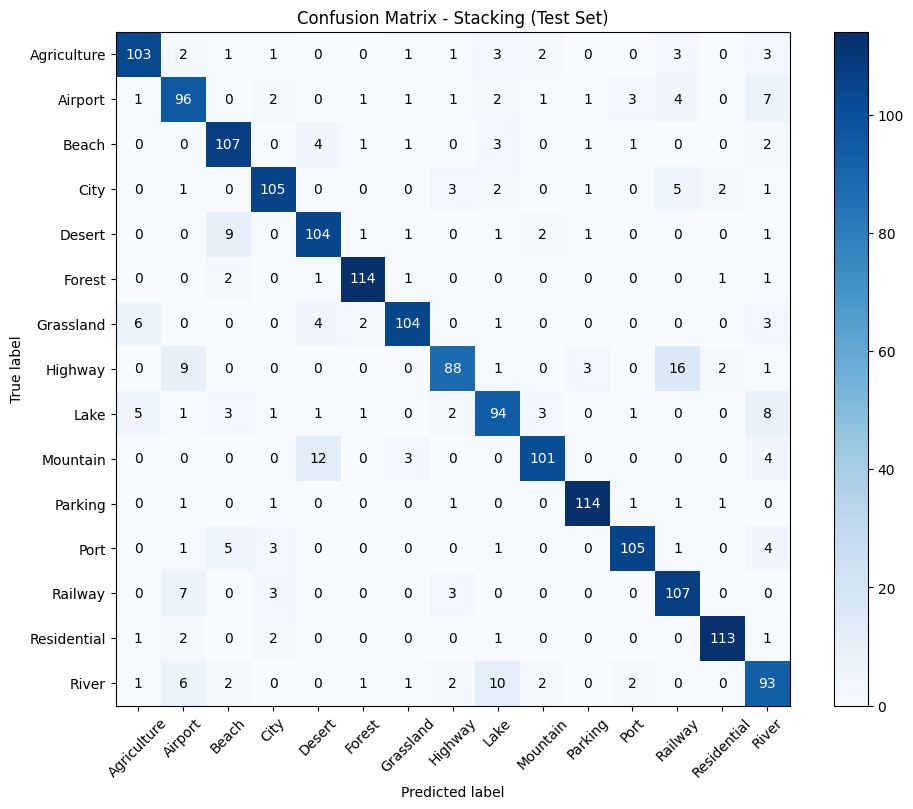


K-means Test Accuracy: 0.4811
K-means Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.46      0.25      0.32       120
     Airport       0.27      0.33      0.30       120
       Beach       0.38      0.64      0.48       120
        City       0.72      0.34      0.46       120
      Desert       0.55      0.42      0.47       120
      Forest       0.74      0.76      0.75       120
   Grassland       0.51      0.57      0.54       120
     Highway       0.40      0.50      0.45       120
        Lake       0.33      0.14      0.20       120
    Mountain       0.44      0.69      0.54       120
     Parking       0.94      0.62      0.75       120
        Port       0.82      0.35      0.49       120
     Railway       0.49      0.58      0.53       120
 Residential       0.47      0.84      0.60       120
       River       0.20      0.17      0.18       120

    accuracy                           0.48      1800
   macro avg      

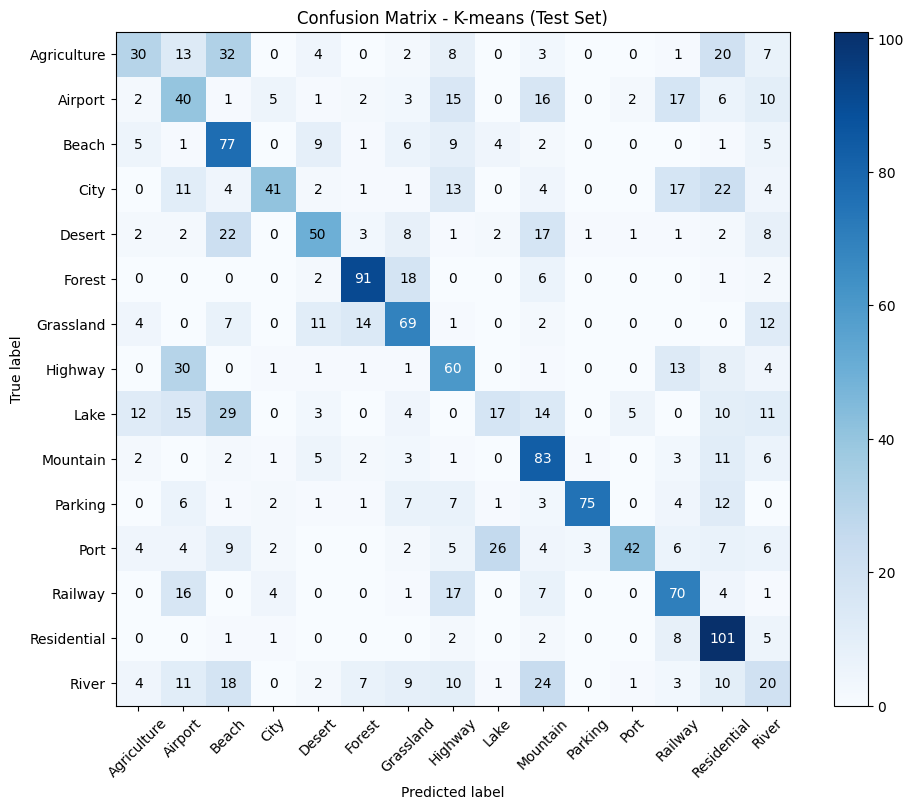


GMM Test Accuracy: 0.5733
GMM Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.88      0.57      0.70       120
     Airport       0.24      0.59      0.34       120
       Beach       0.68      0.67      0.67       120
        City       0.84      0.43      0.57       120
      Desert       0.85      0.53      0.65       120
      Forest       0.94      0.66      0.77       120
   Grassland       0.67      0.62      0.65       120
     Highway       0.83      0.32      0.46       120
        Lake       0.41      0.53      0.46       120
    Mountain       0.59      0.72      0.65       120
     Parking       0.99      0.69      0.81       120
        Port       1.00      0.44      0.61       120
     Railway       0.43      0.41      0.42       120
 Residential       0.77      0.88      0.82       120
       River       0.27      0.54      0.36       120

    accuracy                           0.57      1800
   macro avg       0.69   

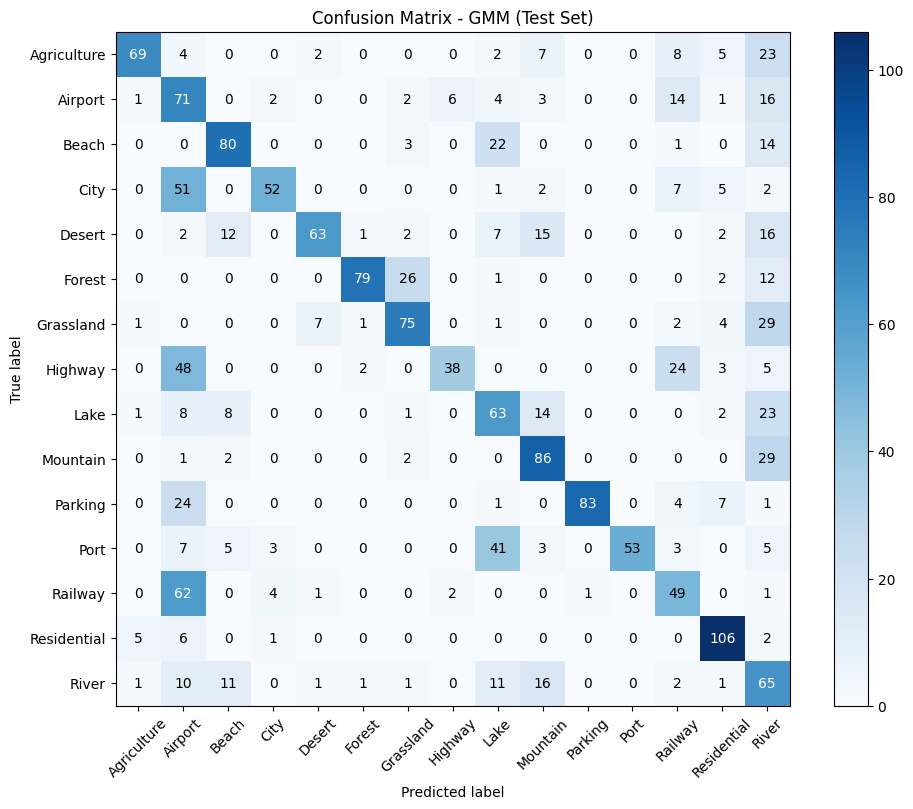


Voting Test Accuracy: 0.8689
Voting Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.88      0.86      0.87       120
     Airport       0.78      0.82      0.80       120
       Beach       0.85      0.88      0.86       120
        City       0.89      0.90      0.89       120
      Desert       0.88      0.83      0.86       120
      Forest       0.94      0.94      0.94       120
   Grassland       0.86      0.89      0.88       120
     Highway       0.86      0.77      0.81       120
        Lake       0.85      0.80      0.82       120
    Mountain       0.90      0.91      0.90       120
     Parking       0.94      0.92      0.93       120
        Port       0.93      0.87      0.90       120
     Railway       0.79      0.89      0.84       120
 Residential       0.93      0.95      0.94       120
       River       0.77      0.82      0.79       120

    accuracy                           0.87      1800
   macro avg       0

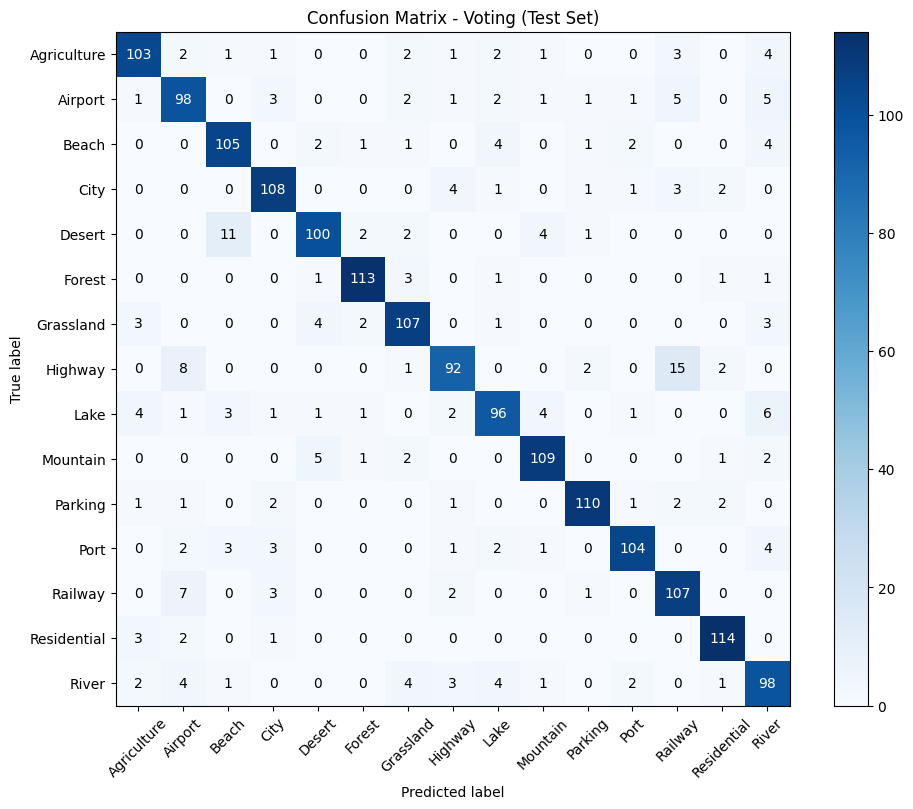


===== FINAL MODEL COMPARISON (TEST SET) =====
SVM: Test Accuracy = 0.8689
  Parameters: {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'}
Voting: Test Accuracy = 0.8689
  Parameters: {'models': ['SVM', 'KNN', 'RF', 'XGBoost', 'CatBoost', 'LogisticRegression']}
Stacking: Test Accuracy = 0.8600
  Parameters: {'estimators': [('rf', RandomForestClassifier(random_state=42)), ('svm', SVC(probability=True, random_state=42)), ('log', LogisticRegression(penalty='l1', random_state=42, solver='saga')), ('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=Non

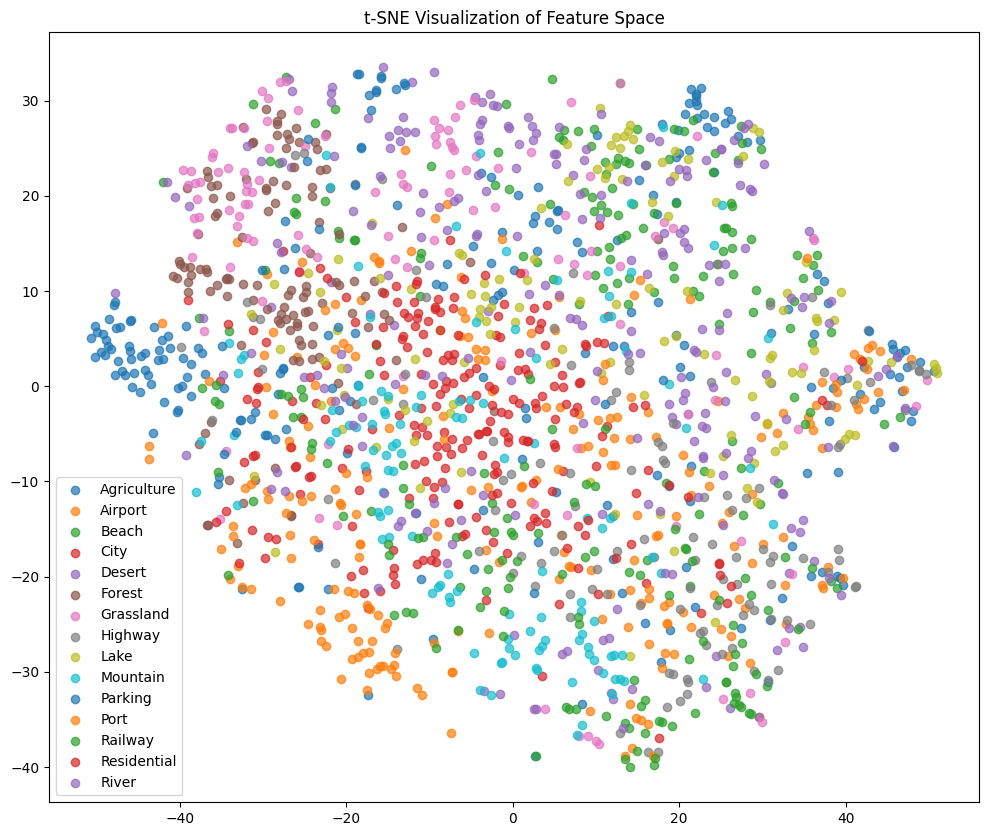


FINAL MODEL RANKING BY TEST ACCURACY:
1. SVM: 0.8689
2. Voting: 0.8689
3. Stacking: 0.8600
4. LogisticRegression: 0.8183
5. XGBoost: 0.8089
6. RF: 0.7972
7. CatBoost: 0.7961
8. KNN: 0.7661
9. GMM: 0.5733
10. K-means: 0.4811


In [42]:
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.manifold import TSNE
import joblib
import torch
from PIL import Image
from torch.utils.data import DataLoader
import xgboost as xgb
import catboost as cb
import warnings
warnings.filterwarnings("ignore")


# Get path for dataset, train, val and test
datasets_dir = Path("datasets")
train_dir = datasets_dir / "train"
val_dir = datasets_dir / "val"
test_dir = datasets_dir / "test"

# Gaussian Mixture Model-based classifier
class GMMClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, n_components=1, covariance_type='full', max_iter=100):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            max_iter=max_iter,
            random_state=42
        )
        self.cluster_to_label_map = {}

    def fit(self, X, y):
        # Fit GMM
        self.gmm.fit(X)

        # Predict cluster assignments for training data
        cluster_labels = self.gmm.predict(X)

        # Map each cluster to the most common class label
        for cluster in range(self.n_components):
            # Find indices of samples in this cluster
            indices = np.where(cluster_labels == cluster)[0]
            if len(indices) > 0:
                # Get the most common class label in this cluster
                most_common_label = np.bincount(y[indices]).argmax()
                self.cluster_to_label_map[cluster] = most_common_label
            else:
                # Handle empty clusters with a default value
                self.cluster_to_label_map[cluster] = 0

        return self

    def predict(self, X):
        # Predict clusters
        cluster_labels = self.gmm.predict(X)

        # Map clusters to class labels
        return np.array([self.cluster_to_label_map[c] for c in cluster_labels])

    def predict_proba(self, X):
        # Get GMM probabilities
        proba = self.gmm.predict_proba(X)

        # Convert to class probabilities
        n_classes = max(self.cluster_to_label_map.values()) + 1
        result = np.zeros((X.shape[0], n_classes))

        for cluster, label in self.cluster_to_label_map.items():
            result[:, label] += proba[:, cluster]

        # Normalise to ensure probabilities sum to 1
        row_sums = result.sum(axis=1, keepdims=True)
        return result / (row_sums + 1e-10)

# K-means based classifier that maps cluster assignments to class labels
class KMeansClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_to_label_map = {}

    def fit(self, X, y):
        # Fit K-means
        self.kmeans.fit(X)

        # Map each cluster to the most common class label
        clusters = self.kmeans.predict(X)
        for cluster in range(self.n_clusters):
            # Find indices of samples in this cluster
            indices = np.where(clusters == cluster)[0]
            if len(indices) > 0:
                # Get the most common class label in this cluster
                most_common_label = np.bincount(y[indices]).argmax()
                self.cluster_to_label_map[cluster] = most_common_label
            else:
                # Handle empty clusters
                self.cluster_to_label_map[cluster] = -1

        return self

    def predict(self, X):
        # Predict clusters
        clusters = self.kmeans.predict(X)

        # Map clusters to class labels
        return np.array([self.cluster_to_label_map.get(c, -1) for c in clusters])

    def predict_proba(self, X):
        # This is a rough approximation for probability
        # based on distance to cluster centers
        distances = self.kmeans.transform(X)

        # Convert distances to similarities (closer = higher probability)
        similarities = 1 / (1 + distances)

        # Normalise to get probabilities
        probabilities = similarities / similarities.sum(axis=1, keepdims=True)

        # Reorder to match class labels
        n_classes = max(self.cluster_to_label_map.values()) + 1
        result = np.zeros((X.shape[0], n_classes))

        for cluster, label in self.cluster_to_label_map.items():
            if label >= 0:  # Skip -1 labels (empty clusters)
                result[:, label] += probabilities[:, cluster]

        # Normalise again
        row_sums = result.sum(axis=1, keepdims=True)
        return result / (row_sums + 1e-10)  # Add small constant to avoid division by zero

# Create a Random Forest classifier
def create_random_forest(n_estimators=100, max_depth=None, max_features='sqrt', bootstrap=True):
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

# Create an XG Boost classifier
def create_xgboost(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8):
    return xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective="multi:softprob",  # For multi-class classification
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'  # For multi-class classification
    )

# Create a Bagging classifier
def create_bagging(base_estimator=None, n_estimators=10, max_samples=1.0, bootstrap=True):

    return BaggingClassifier(
        base_estimator=base_estimator,
        n_estimators=n_estimators,
        max_samples=max_samples,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

# Create a Voting classifier
def create_voting_classifier(estimators, voting='hard', weights=None):
    return VotingClassifier(
        estimators=estimators,
        voting=voting,
        weights=weights,
        n_jobs=-1
    )

# Create a Stacking classifer
def create_stacking_classifier(estimators=None, final_estimator=None, cv=5):
    if estimators is None:
        # Default base estimators
        estimators = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svm', SVC(probability=True, random_state=42)),
            ('log', LogisticRegression(C=1.0, penalty='l1', solver='saga', random_state=42)),
            ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
        ]

    if final_estimator is None:
        # Default meta-estimator
        final_estimator = LogisticRegression(random_state=42)

    return StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=cv,
        n_jobs=-1
    )

def evaluate_unsupervised_clustering(X, y, method='kmeans', n_clusters_range=None, **kwargs):

    if n_clusters_range is None:
        n_unique_classes = len(np.unique(y))
        n_clusters_range = [
            max(2, n_unique_classes - 1),
            n_unique_classes,
            n_unique_classes + 1,
            n_unique_classes * 2
        ]

    best_score = -1
    best_model = None
    best_metrics = {}

    # For other methods, try different n_clusters
    for n_clusters in n_clusters_range:
        # Create clustering model
        if method == 'kmeans':
            cluster_model = KMeans(n_clusters=n_clusters, random_state=42)
        elif method == 'gmm':
            covariance_type = kwargs.get('covariance_type', 'full')
            cluster_model = GaussianMixture(
                n_components=n_clusters,
                covariance_type=covariance_type,
                random_state=42
            )
        else:
            raise ValueError(f"Unknown clustering method: {method}")

        # Fit model and get cluster labels
        cluster_labels = cluster_model.fit_predict(X)

        # Calculate metrics
        try:
            silhouette = silhouette_score(X, cluster_labels)
            calinski = calinski_harabasz_score(X, cluster_labels)

            # Map clusters to most common ground truth labels
            mapped_labels = np.zeros_like(cluster_labels)
            for cluster in range(n_clusters):
                indices = np.where(cluster_labels == cluster)[0]
                if len(indices) > 0:
                    most_common = np.bincount(y[indices]).argmax()
                    mapped_labels[indices] = most_common

            # Calculate accuracy of mapped labels
            accuracy = accuracy_score(y, mapped_labels)

            # Combine metrics (weighted average)
            # Normalize calinski score to 0-1 range (approximately)
            normalized_calinski = min(1.0, calinski / 1000)
            combined_score = (silhouette + normalized_calinski + accuracy) / 3

            if combined_score > best_score:
                best_score = combined_score
                best_model = cluster_model
                best_metrics = {
                    'n_clusters': n_clusters,
                    'silhouette': silhouette,
                    'calinski_harabasz': calinski,
                    'accuracy': accuracy
                }

                # Add method-specific metrics
                if method == 'kmeans':
                    best_metrics['inertia'] = cluster_model.inertia_
                elif method == 'gmm':
                    best_metrics['covariance_type'] = covariance_type
                    best_metrics['bic'] = cluster_model.bic(X)
                    best_metrics['aic'] = cluster_model.aic(X)

        except Exception as e:
            # Skip configurations that cause errors
            print(f"Error with {method} (n_clusters={n_clusters}): {e}")
            continue

    return best_model, best_metrics

# Try different hyperparameters for a model and return the best one.
def try_hyperparameters(X_train, y_train, X_val, y_val, model_type, class_names, pca_n_components):

    best_model = None
    best_params = None
    best_accuracy = 0.0

    # Define PCA component options for tuning
    # Use smaller values for small datasets, larger values for larger feature spaces
    max_components = min(X_train.shape[1], 100)  # Cap at original dimension or 100
    pca_components = [
        max(5, int(max_components * 0.1)),   # 10% of max
        max(10, int(max_components * 0.25)),  # 25% of max
        max(20, int(max_components * 0.5)),   # 50% of max
        max(30, int(max_components * 0.75)),  # 75% of max
        max(40, int(max_components * 0.95)),  # 95% of max
        max_components,  # Maximum (100% or 100, whichever is smaller)
        None  # No PCA - use all features
    ]

    # Remove duplicates and sort (putting None at the end)
    pca_components = sorted([c for c in set(pca_components) if c is not None]) + [None]

    # Define model-specific hyperparameters
    if model_type == 'SVM':
        model_params = [
            # RBF kernel with various C values and gamma settings
            {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'},
            {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'},
            {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'},
            {'kernel': 'rbf', 'C': 100, 'gamma': 'scale'},
            {'kernel': 'rbf', 'C': 1000, 'gamma': 'scale'},
            # Add linear kernel since it sometimes performs better
            {'kernel': 'linear', 'C': 1},
            {'kernel': 'linear', 'C': 10},
            # Add polynomial kernel
            {'kernel': 'poly', 'C': 10, 'degree': 2, 'gamma': 'scale'},
        ]
    elif model_type == 'KNN':
        model_params = [
            {'n_neighbors': 1, 'weights': 'uniform'},
            {'n_neighbors': 3, 'weights': 'uniform'},
            {'n_neighbors': 5, 'weights': 'uniform'},
            {'n_neighbors': 7, 'weights': 'uniform'},
            {'n_neighbors': 1, 'weights': 'distance'},
            {'n_neighbors': 3, 'weights': 'distance'},
            {'n_neighbors': 5, 'weights': 'distance'},
            {'n_neighbors': 7, 'weights': 'distance'},
            {'n_neighbors': 9, 'weights': 'distance'},
        ]
    elif model_type == 'K-means':
        model_params = [
            {'n_clusters': len(class_names)},
            {'n_clusters': len(class_names) * 2},
            {'n_clusters': len(class_names) * 3},
            {'n_clusters': max(len(class_names) // 2, 2)},
            {'n_clusters': min(len(class_names) * 4, 30)}
        ]
    elif model_type == 'RF':
        model_params = [
            {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt'},
            {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'},
            {'n_estimators': 200, 'max_depth': None, 'max_features': 'sqrt'},
            {'n_estimators': 100, 'max_depth': 10, 'max_features': 'sqrt'},
            {'n_estimators': 100, 'max_depth': 20, 'max_features': 'sqrt'},
            {'n_estimators': 100, 'max_depth': None, 'max_features': 'log2'},
            {'n_estimators': 100, 'max_depth': None, 'max_features': None}
        ]
    elif model_type == 'XGBoost':
        model_params = [
            {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8},
            {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8},
            {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8},
            {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8},
            {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0},
            {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6},
            {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8},
            {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8}
        ]
    elif model_type == 'CatBoost':
        model_params = [
            {'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3},
            {'iterations': 200, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3},
            {'iterations': 100, 'learning_rate': 0.05, 'depth': 6, 'l2_leaf_reg': 3},
            {'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1},
            {'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 10}
        ]
    elif model_type == 'LogisticRegression':
        model_params = [
            {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'},
            {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'},
            {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'},
            {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'},
            {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'},
            {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'},
            {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'},
            {'C': 10.0, 'penalty': 'l1', 'solver': 'saga'},
            {'C': 1.0, 'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5}
        ]
    elif model_type == 'Stacking':
        # For stacking, we'll use a fixed set of base models and try different final estimators
        base_estimators = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svm', SVC(probability=True, random_state=42)),
            ('log', LogisticRegression(C=1.0, penalty='l1', solver='saga', random_state=42)),
            ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
        ]
        model_params = [
            {'estimators': base_estimators, 'final_estimator': LogisticRegression(random_state=42), 'cv': 3},
            {'estimators': base_estimators, 'final_estimator': LogisticRegression(random_state=42), 'cv': 5},
            {'estimators': base_estimators, 'final_estimator': RandomForestClassifier(n_estimators=50, random_state=42), 'cv': 3},
            {'estimators': base_estimators, 'final_estimator': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 'cv': 3}
        ]
    elif model_type == 'Bagging':
        model_params = [
            {'n_estimators': 10, 'max_samples': 0.8},
            {'n_estimators': 10, 'max_samples': 1.0},
            {'n_estimators': 20, 'max_samples': 0.8},
            {'n_estimators': 20, 'max_samples': 1.0}
        ]
    elif model_type == 'GMM':
        model_params = [
            {'n_components': len(class_names), 'covariance_type': 'full'},
            {'n_components': len(class_names) * 2, 'covariance_type': 'full'},
            {'n_components': len(class_names), 'covariance_type': 'tied'},
            {'n_components': len(class_names) * 2, 'covariance_type': 'tied'},
            {'n_components': len(class_names), 'covariance_type': 'diag'},
            {'n_components': len(class_names) * 2, 'covariance_type': 'diag'}
        ]
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Try combinations of PCA components and model hyperparameters
    print(f"  Testing PCA components: {pca_components}")

    for n_components in pca_components:
        for params in model_params:
            start_time = time.time()

            # Create pipeline with current hyperparameters
            pipeline_steps = []

            # Always start with scaling
            pipeline_steps.append(('scaler', StandardScaler()))

            # Add PCA if n_components is not None
            if n_components is not None:
                pipeline_steps.append(('pca', PCA(n_components=n_components)))

            # Add the model
            if model_type == 'SVM':
                pipeline_steps.append(('model', SVC(probability=True, random_state=42, **params)))
            elif model_type == 'KNN':
                pipeline_steps.append(('model', KNeighborsClassifier(**params)))
            elif model_type == 'K-means':
                pipeline_steps.append(('model', KMeansClassifier(**params)))
            elif model_type == 'RF':
                pipeline_steps.append(('model', RandomForestClassifier(random_state=42, **params)))
            elif model_type == 'XGBoost':
                pipeline_steps.append(('model', xgb.XGBClassifier(
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='mlogloss',
                    objective="multi:softprob",
                    n_jobs=-1,
                    **params
                )))
            elif model_type == 'CatBoost':
                pipeline_steps.append(('model', cb.CatBoostClassifier(
                    random_seed=42,
                    verbose=0,
                    thread_count=-1,
                    **params
                )))
            elif model_type == 'LogisticRegression':
                pipeline_steps.append(('model', LogisticRegression(
                    random_state=42,
                    max_iter=1000,
                    multi_class='multinomial',
                    n_jobs=-1,
                    **params
                )))
            elif model_type == 'Stacking':
                pipeline_steps.append(('model', create_stacking_classifier(**params)))
            elif model_type == 'Bagging':
                # Use SVC as base estimator for bagging
                svc = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)
                pipeline_steps.append(('model', BaggingClassifier(base_estimator=svc, random_state=42, **params)))
            elif model_type == 'GMM':
                pipeline_steps.append(('model', GMMClassifier(**params)))

            pipeline = Pipeline(pipeline_steps)

            # Train model
            try:
                pipeline.fit(X_train, y_train)

                # Evaluate on validation set
                y_pred = pipeline.predict(X_val)
                accuracy = accuracy_score(y_val, y_pred)

                end_time = time.time()

                pca_str = f"PCA={n_components}" if n_components is not None else "No PCA"
                print(f"  {model_type} {params}, {pca_str}: Val Acc = {accuracy:.4f} (Time: {end_time - start_time:.2f}s)")

                # Check if this is the best model so far
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'model_params': params, 'pca_components': n_components}
                    best_model = pipeline
            except Exception as e:
                print(f"  Error with {model_type} {params}, {pca_str}: {e}")
                continue

    if best_model is None:
        print(f"Warning: Could not find a working model for {model_type}. Using default parameters.")

        # Create a default model as fallback
        if model_type == 'XGBoost':
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', xgb.XGBClassifier(
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='mlogloss',
                    n_jobs=-1
                ))
            ])
        elif model_type == 'CatBoost':
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', cb.CatBoostClassifier(
                    random_seed=42,
                    verbose=0,
                    thread_count=-1
                ))
            ])
        elif model_type == 'LogisticRegression':
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(
                    random_state=42,
                    max_iter=1000,
                    multi_class='multinomial',
                    n_jobs=-1
                ))
            ])
        elif model_type == 'Stacking':
            base_estimators = [
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('svm', SVC(probability=True, random_state=42)),
                ('log', LogisticRegression(C=1.0, penalty='l1', solver='saga', random_state=42)),
                ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
            ]
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', StackingClassifier(
                    estimators=base_estimators,
                    final_estimator=LogisticRegression(random_state=42),
                    cv=3,
                    n_jobs=-1
                ))
            ])
        elif model_type == 'SVM':
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', SVC(probability=True, random_state=42))
            ])
        elif model_type == 'KNN':
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=5))
            ])
        elif model_type == 'RF':
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))
            ])
        else:
            # Use random forest as a fallback for any other model
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))
            ])

        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = {'model_params': {}, 'pca_components': None}
        best_accuracy = 0.0
    else:
        print(f"Best {model_type} hyperparameters: {best_params}")
        print(f"Best {model_type} validation accuracy: {best_accuracy:.4f}")

    return best_model, best_params, best_accuracy

# Train a final model on combined training and validation data
def train_final_model(X_combined, y_combined, model_type, best_params, pca_n_components):

    print(f"\nTraining final {model_type} model with best hyperparameters on combined data...")

    # Extract model-specific params and PCA components
    model_params = best_params['model_params']
    n_components = best_params['pca_components']

    pca_str = f"{n_components} PCA components" if n_components is not None else "No PCA"
    print(f"  Using {pca_str} and model parameters: {model_params}")

    # Create pipeline with best hyperparameters
    pipeline_steps = []

    # Always start with scaling
    pipeline_steps.append(('scaler', StandardScaler()))

    # Add PCA if n_components is not None
    if n_components is not None:
        pipeline_steps.append(('pca', PCA(n_components=n_components)))

    # Add the model
    if model_type == 'SVM':
        pipeline_steps.append(('model', SVC(probability=True, random_state=42, **model_params)))
    elif model_type == 'KNN':
        pipeline_steps.append(('model', KNeighborsClassifier(**model_params)))
    elif model_type == 'K-means':
        pipeline_steps.append(('model', KMeansClassifier(**model_params)))
    elif model_type == 'RF':
        pipeline_steps.append(('model', RandomForestClassifier(random_state=42, **model_params)))
    elif model_type == 'XGBoost':
        pipeline_steps.append(('model', xgb.XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss',
            objective="multi:softprob",
            n_jobs=-1,
            **model_params
        )))
    elif model_type == 'CatBoost':
        pipeline_steps.append(('model', cb.CatBoostClassifier(
            random_seed=42,
            verbose=0,
            thread_count=-1,
            **model_params
        )))
    elif model_type == 'LogisticRegression':
        pipeline_steps.append(('model', LogisticRegression(
            random_state=42,
            max_iter=1000,
            multi_class='multinomial',
            n_jobs=-1,
            **model_params
        )))
    elif model_type == 'Stacking':
        pipeline_steps.append(('model', create_stacking_classifier(**model_params)))
    elif model_type == 'Bagging':
        # Use SVC as base estimator for bagging
        svc = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)
        pipeline_steps.append(('model', BaggingClassifier(base_estimator=svc, random_state=42, **model_params)))
    elif model_type == 'GMM':
        pipeline_steps.append(('model', GMMClassifier(**model_params)))

    pipeline = Pipeline(pipeline_steps)

    # Train model on combined data
    pipeline.fit(X_combined, y_combined)

    return pipeline

# Evaluate a model on test data
def evaluate_model(model, X_test, y_test, class_names, model_type):

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=list(class_names.values()))
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n{model_type} Test Accuracy: {accuracy:.4f}")
    print(f"{model_type} Classification Report:\n{report}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_type} (Test Set)')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, list(class_names.values()), rotation=45)
    plt.yticks(tick_marks, list(class_names.values()))

    # Add text annotations in the confusion matrix
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return accuracy, report, conf_matrix

# ---------------------- Main Function ----------------------

def main(sample_size=None, feature_type='combined', n_augmentations=5, batch_size=32):

    # Check if dataset exists
    if not train_dir.exists() or not val_dir.exists() or not test_dir.exists():
        raise FileNotFoundError(
            "Dataset directories not found. Please run split_dataset.py first."
        )

    # Create augmentation generator
    augmentor = AugmentationGenerator()

    # Handle different sample size formats
    train_sample_size = sample_size
    val_sample_size = sample_size
    test_sample_size = sample_size

    # If sample_size is a dictionary, extract the specific sample sizes
    if isinstance(sample_size, dict):
        train_sample_size = sample_size.get('train', None)
        val_sample_size = sample_size.get('val', None)
        test_sample_size = sample_size.get('test', None)

    print("\nStep 1: Creating dataloaders...")
    # Create dataloaders for training and validation sets
    # Pass specific sample sizes for train and validation datasets
    train_dataset, val_dataset = augmentor.create_datasets(
        train_dir, val_dir, sample_size=train_sample_size, val_sample_size=val_sample_size
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Create a data loader for test set
    test_dataset = augmentor.create_datasets(
        test_dir, test_dir, sample_size=test_sample_size
    )[0]  # Just use the first returned dataset
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Get class names from the train dataset
    class_indices = {idx: classname for classname, idx in train_loader.dataset.class_to_idx.items()}
    print(f"Classes: {class_indices}")

    # Step 2: Create feature extractor and codebook
    feature_extractor = FeatureExtractor(feature_type=feature_type)

    print("\nStep 2: Creating codebook for bag of visual words...")
    if feature_type in ['sift', 'combined']:
        feature_extractor.create_codebook(train_loader, n_clusters=200)
        # The codebook is stored in the feature_extractor object itself

    # Step 3: Extract features from training images
    print("\nStep 3: Extracting features from training images...")
    X_train, y_train = feature_extractor.extract_features_batch(train_loader)

    # Step 4: Extract features from validation images
    print("\nStep 4: Extracting features from validation images...")
    X_val, y_val = feature_extractor.extract_features_batch(val_loader)

    print("\nFeature extraction complete:")
    print(f"Train: {X_train.shape} features, {y_train.shape} labels")
    print(f"Validation: {X_val.shape} features, {y_val.shape} labels")

    # Step 5: Try different hyperparameters and select the best for each model
    pca_n_components = min(100, X_train.shape[1])  # Limit to 100 components or feature dimension

    # Try hyperparameters for each model type and select the best
    best_models = {}
    best_params = {}

    print("\nStep 5: Finding optimal hyperparameters...")

    # List of models to try
    model_types = [
        # Supervised methods
        'SVM', 'KNN', 'RF', 'XGBoost', 'CatBoost', 'LogisticRegression', 'Stacking', 'Bagging',
        # Unsupervised methods
        'K-means', 'GMM'
    ]

    for model_type in model_types:
        print(f"\nTrying hyperparameters for {model_type}...")
        try:
            best_model, params, accuracy = try_hyperparameters(
                X_train, y_train, X_val, y_val, model_type, class_indices, pca_n_components
            )
            best_models[model_type] = best_model
            best_params[model_type] = params
        except Exception as e:
            print(f"Error training {model_type}: {e}")
            print(f"Skipping {model_type} model")

    # Step 6: Create and evaluate ensemble models
    print("\nStep 6: Creating ensemble models...")

    # Create a voting ensemble from the best individual models
    voting_classifiers = []
    for model_type, model in best_models.items():
        # Only include supervised classifiers with decent performance
        if model_type in ['SVM', 'KNN', 'RF', 'XGBoost', 'CatBoost', 'LogisticRegression'] and hasattr(model, 'predict_proba'):
            voting_classifiers.append((model_type, model))

    if len(voting_classifiers) >= 2:
        # Create soft voting ensemble
        voting_ensemble = VotingClassifier(
            estimators=voting_classifiers,
            voting='soft'
        )

        # Train on combined data
        print("Training Voting Ensemble model...")
        voting_ensemble.fit(X_train, y_train)

        # Evaluate on validation set
        y_pred = voting_ensemble.predict(X_val)
        voting_acc = accuracy_score(y_val, y_pred)
        print(f"Voting Ensemble Validation Accuracy: {voting_acc:.4f}")

        # Add to best models
        best_models['Voting'] = voting_ensemble
        best_params['Voting'] = {'models': [name for name, _ in voting_classifiers]}
    else:
        print("Not enough models for a voting ensemble")

    # Step 7: Combine training and validation data
    print("\nStep 7: Combining training and validation data for final model training...")
    X_combined = np.vstack((X_train, X_val))
    y_combined = np.concatenate((y_train, y_val))
    print(f"Combined data shape: {X_combined.shape}")

    # Step 8: Train final models on combined data with best hyperparameters
    final_models = {}

    print("\nStep 8: Training final models with best hyperparameters...")
    for model_type, model in best_models.items():
        if model_type in ['Voting', 'Custom_Ensemble']:
            # Retrain ensemble models on combined data
            model.fit(X_combined, y_combined)
            final_models[model_type] = model
        elif model_type in best_params:
            # Train regular models using train_final_model function
            final_models[model_type] = train_final_model(
                X_combined, y_combined, model_type, best_params[model_type], pca_n_components
            )
        # Save the final model
        try:
            joblib.dump(final_models[model_type], f'final_{model_type.lower()}_model.pkl')
        except Exception as e:
            print(f"Error saving {model_type} model: {e}")

    # Step 9: Extract features from test images
    print("\nStep 9: Extracting features from test images...")
    X_test, y_test = feature_extractor.extract_features_batch(test_loader)

    # Step 10: Evaluate final models on test set
    print("\nStep 10: Evaluating final models on test set...")
    results = {}

    for model_type, model in final_models.items():
        try:
            accuracy, report, conf_matrix = evaluate_model(model, X_test, y_test, class_indices, model_type)

            results[model_type] = {
                'model': model,
                'params': best_params.get(model_type, {}),
                'accuracy': accuracy,
                'report': report,
                'conf_matrix': conf_matrix
            }
        except Exception as e:
            print(f"Error evaluating {model_type}: {e}")
            continue

    # Step 11: Compare final results
    print("\n===== FINAL MODEL COMPARISON (TEST SET) =====")
    for model_type, result in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
        print(f"{model_type}: Test Accuracy = {result['accuracy']:.4f}")
        if isinstance(result['params'], dict) and 'model_params' in result['params']:
            print(f"  Parameters: {result['params']['model_params']}")
        else:
            print(f"  Parameters: {result['params']}")

    # Step 12: Visualize feature space using t-SNE (optional)
    try:
        print("\nStep 12: Visualizing feature space with t-SNE...")
        # Apply PCA first to reduce dimensionality (for faster t-SNE)
        pca = PCA(n_components=min(50, X_test.shape[1]))
        X_pca = pca.fit_transform(X_test)

        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(X_pca)

        # Plot t-SNE visualization
        plt.figure(figsize=(12, 10))
        for class_idx in np.unique(y_test):
            # Get data points for this class
            mask = y_test == class_idx
            plt.scatter(
                X_tsne[mask, 0], X_tsne[mask, 1],
                label=class_indices.get(class_idx, f'Class {class_idx}'),
                alpha=0.7
            )

        plt.title('t-SNE Visualization of Feature Space')
        plt.legend()
        plt.savefig('feature_space_tsne.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error creating t-SNE visualization: {e}")

    return results

# ---------------------- Script Execution ----------------------

if __name__ == "__main__":
    # Set to True for quick testing with a small sample
    quick_test = False

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if quick_test:
        # Calculate sample sizes based on the original 7:1.5:1.5 ratio
        total_sample_size = 100  # Total samples per class across all splits
        train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

        # Define a sample size dictionary to pass to the main function
        sample_sizes = {
            'train': int(total_sample_size * train_ratio),  # 70 samples
            'val': max(1, int(total_sample_size * val_ratio)),  # ~15 samples
            'test': max(1, int(total_sample_size * test_ratio))  # ~15 samples
        }

        print("QUICK TEST MODE: Using proportional samples for testing")
        print(f"Sample sizes per class - Train: {sample_sizes['train']}, Val: {sample_sizes['val']}, Test: {sample_sizes['test']}")
        results = main(sample_size=sample_sizes, n_augmentations=2, batch_size=16)
    else:
        print("FULL DATASET MODE: Using all available images")
        results = main(sample_size=None, n_augmentations=3, batch_size=32)
    import csv
    csv_file = 'file.csv'
    # Writing to CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Key', 'Value'])

        # Write data
        for key, value in results.items():
            writer.writerow([key, value])

    # Print final ranking of models
    print("\nFINAL MODEL RANKING BY TEST ACCURACY:")
    for i, (model_type, result) in enumerate(sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True), 1):
        print(f"{i}. {model_type}: {result['accuracy']:.4f}")

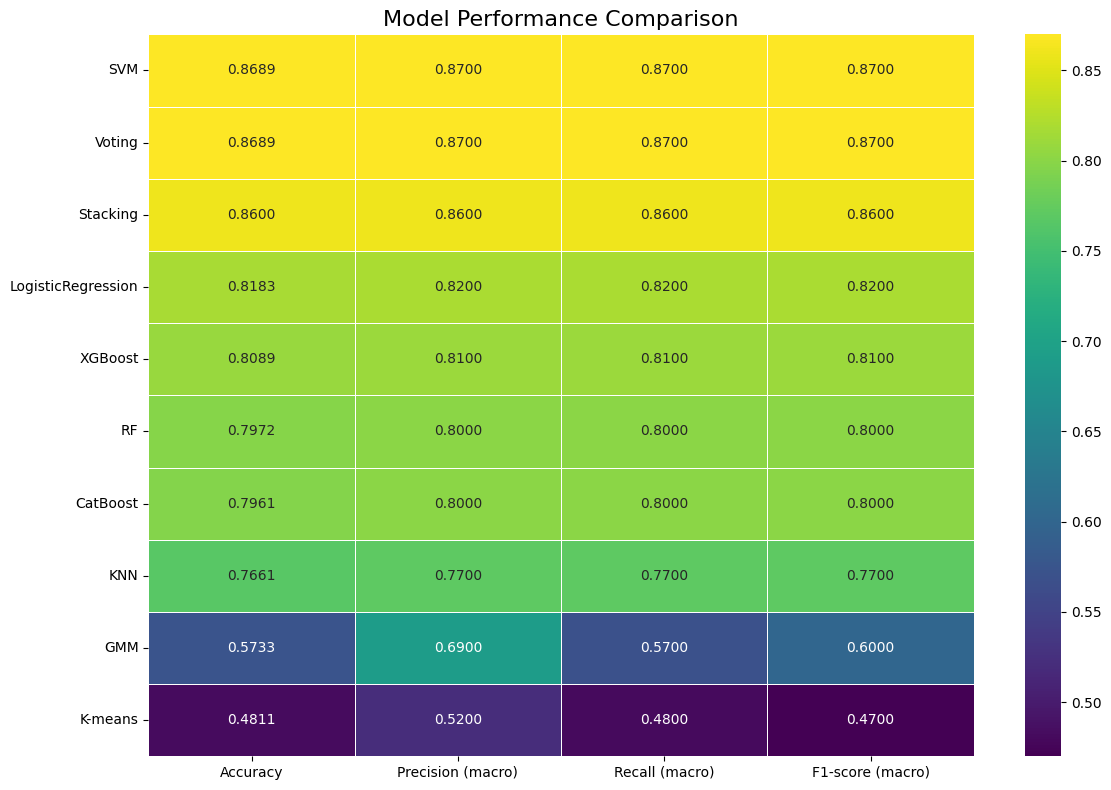

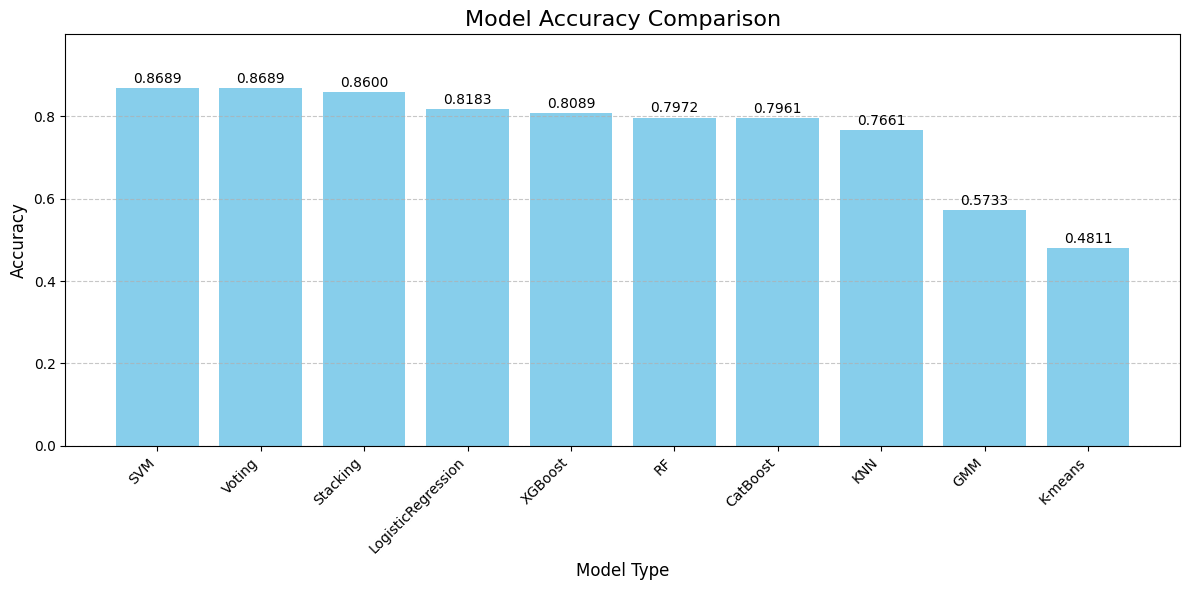

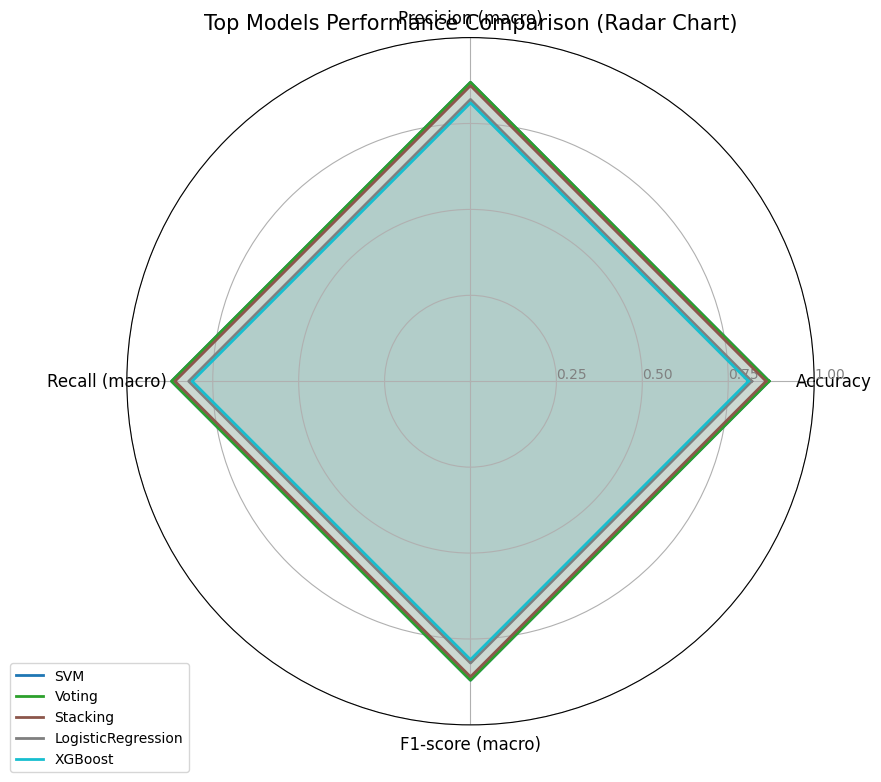

SyntaxError: 'return' outside function (<ipython-input-43-e4f4eb19ed9d>, line 121)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Extract model names
model_names = list(results.keys())

# Define metrics to compare
metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-score (macro)']

# Create a matrix to store all metrics
metrics_matrix = np.zeros((len(model_names), len(metrics)))

# Fill the matrix with metric values
for i, model_name in enumerate(model_names):
    model_result = results[model_name]

    # Add accuracy
    metrics_matrix[i, 0] = model_result['accuracy']

    # Parse classification report for other metrics
    # The report string needs to be parsed
    report_lines = model_result['report'].strip().split('\n')

    # Find the line with 'macro avg'
    for line in report_lines:
        if 'macro avg' in line:
            parts = line.split()
            # Format is typically: 'macro avg' precision recall f1-score support
            metrics_matrix[i, 1] = float(parts[2])  # Precision
            metrics_matrix[i, 2] = float(parts[3])  # Recall
            metrics_matrix[i, 3] = float(parts[4])  # F1-score
            break

# Create a DataFrame for better visualization
df_metrics = pd.DataFrame(metrics_matrix, index=model_names, columns=metrics)

# Sort models by accuracy (highest first)
df_metrics = df_metrics.sort_values(by='Accuracy', ascending=False)

# Create figure
plt.figure(figsize=(12, 8))

# Generate heatmap
sns.heatmap(df_metrics, annot=True, cmap='viridis', fmt='.4f', linewidths=0.5)

plt.title('Model Performance Comparison', fontsize=16)
plt.tight_layout()
plt.savefig('model_performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Also create a bar chart of accuracies
plt.figure(figsize=(12, 6))

# Sort by accuracy
accuracy_series = df_metrics['Accuracy'].sort_values(ascending=False)

# Create bar chart
bars = plt.bar(accuracy_series.index, accuracy_series.values, color='skyblue')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom', rotation=0)

plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylim(0, min(1.0, max(accuracy_series.values) * 1.15))  # Add some headroom for text
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a radar chart to compare top models
plt.figure(figsize=(10, 8))

# Get top 5 models or fewer if we have less
top_models = min(5, len(df_metrics))
top_df = df_metrics.iloc[:top_models]

# Set up the radar chart
categories = metrics
N = len(categories)

# Create angle for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create subplot with polar projection
ax = plt.subplot(111, polar=True)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories, size=12)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.50", "0.75", "1.00"], color="grey", size=10)
plt.ylim(0, 1)

# Plot each model
colors = plt.cm.tab10(np.linspace(0, 1, top_models))

for i, (model_name, row) in enumerate(top_df.iterrows()):
    values = row.values.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Top Models Performance Comparison (Radar Chart)', size=15)
plt.tight_layout()
plt.savefig('model_radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
